In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from importlib import reload
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, GlobalMaxPooling2D, Lambda
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Model

In [2]:
IMG_SIZE = (256, 256, 3)
NUM_FEATS = 2000

In [3]:
def img_preprocess(imgs):
    imgs = tf.image.resize(imgs, IMG_SIZE[:2], method='bilinear')
    imgs = tf.cast(imgs, tf.uint8)
    return imgs

def model_preprocess(x):
    x = Rescaling(1/255)(x)
    return x

def make_model(input_shape):
    base_model = ResNet50(include_top=False, pooling=None, weights=None,
                          input_shape=input_shape)
    
    inputs = Input(shape=input_shape)
    x = model_preprocess(inputs)
    x = base_model(x)
    x = Lambda(lambda x: x, name='lambda_1')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
model = make_model(IMG_SIZE)
model.build(IMG_SIZE)
# model.load_weights('/content/drive/MyDrive/TeamSemiSuperCV/Wing/FSL_Benchmarks/FSL_ResNet50_XrayRemix.h5')
model.load_weights('./FSL_ResNet50_XrayRemix.h5')
model.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
lambda_1 (Lambda)            (None, 8, 8, 2048)        0         
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192  

In [5]:
model_d = Model(inputs=model.input, outputs=model.layers[-4].output)
model_d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
lambda_1 (Lambda)            (None, 8, 8, 2048)        0         
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192

In [6]:
ds = tfds.load('xray_remix')
ds_train = ds['train']
ds_valid = ds['validation']
ds_test = ds['test']

In [7]:
ds_train_xy = ds_train.map(lambda d: (d['image'], d['label']))
ds_train_xy = ds_train_xy.map(lambda x, y: (img_preprocess(x), y))
ds_train_xy.element_spec

(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
feats = []
labels = []
for batch_x, batch_y in ds_train_xy.batch(512):
  print(batch_x.shape, batch_y.shape)
  feats.append(model_d(batch_x, training=False))
  labels.append(batch_y)

(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(101, 256, 256, 3) (101,)


In [9]:
feats = np.concatenate(feats)
labels = np.concatenate(labels)
feats.shape, labels.shape

((4709, 64), (4709,))

In [29]:
# Sample a reduced set of features
feats_idxs = np.arange(len(feats))
np.random.seed(44)
np.random.shuffle(feats_idxs)
feats_sm = np.empty((NUM_FEATS, *feats.shape[1:]), dtype=np.float32)
labels_sm = np.empty((NUM_FEATS,), dtype=np.int32)
for i, idx in enumerate(feats_idxs[:NUM_FEATS]):
  feats_sm[i] = feats[idx]
  labels_sm[i] = labels[idx]

In [30]:
# npz_file = '/content/drive/MyDrive/TeamSemiSuperCV/Wing/FSL_Benchmarks/FSL_ResNet50_XrayRemix_Feats.npz'
npz_file = './tsne_feats.npz'
np.savez(npz_file, feats=feats_sm, labels=labels_sm)

In [31]:
npz = np.load(npz_file)
npz['feats'].shape, npz['labels'].shape

((2000, 64), (2000,))

In [32]:
npz['feats'][0]

array([0.   , 8.011, 5.519, 6.262, 0.   , 7.01 , 7.823, 7.238, 0.   ,
       0.   , 0.   , 7.004, 0.   , 0.   , 0.   , 7.755, 5.282, 6.336,
       0.   , 0.69 , 0.   , 6.983, 2.068, 6.188, 0.   , 0.   , 0.   ,
       8.278, 6.984, 0.495, 3.818, 3.189, 7.822, 0.   , 4.159, 5.809,
       0.   , 5.573, 1.184, 7.49 , 9.112, 3.208, 0.   , 2.608, 9.479,
       7.17 , 6.161, 7.057, 5.622, 7.591, 0.   , 4.707, 6.606, 7.569,
       0.   , 6.857, 0.   , 6.568, 0.   , 7.977, 0.   , 6.928, 0.   ,
       6.186], dtype=float32)

In [33]:
npz['labels'][:50]

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1], dtype=int32)

In [34]:
# openTSNE supports separate fit() and transform()
from openTSNE import TSNE

In [59]:
tsne = TSNE(
    perplexity=12,
    metric="euclidean",
    n_jobs=4,
    random_state=42,
)
embeddings = tsne.fit(feats_sm)
embeddings.shape

(2000, 2)

In [60]:
colormap = np.array(['r', 'b', 'k'])

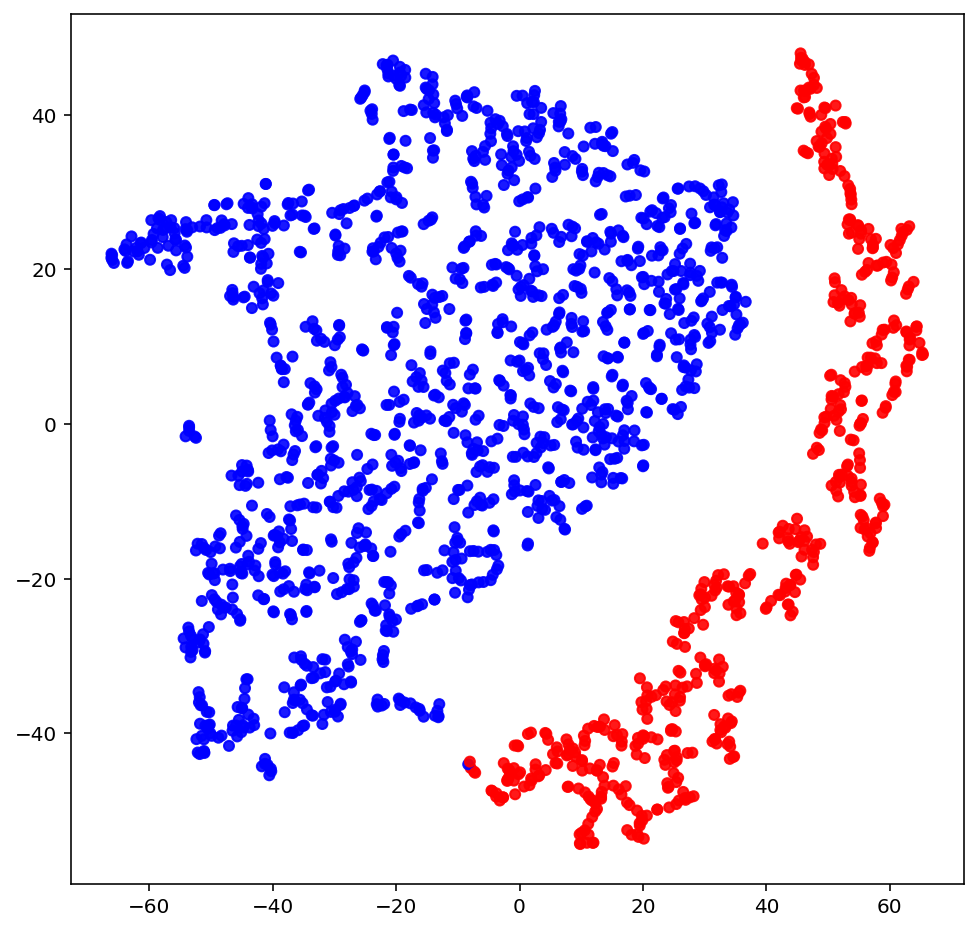

In [61]:
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=colormap[labels_sm], s=25, alpha=0.9);

In [62]:
for i in range(50):
  if labels_sm[i] == 0:
    print(i, end=' ')

0 3 4 5 8 9 10 16 21 24 29 32 33 35 38 41 48 

[[-28.981  -6.094]]


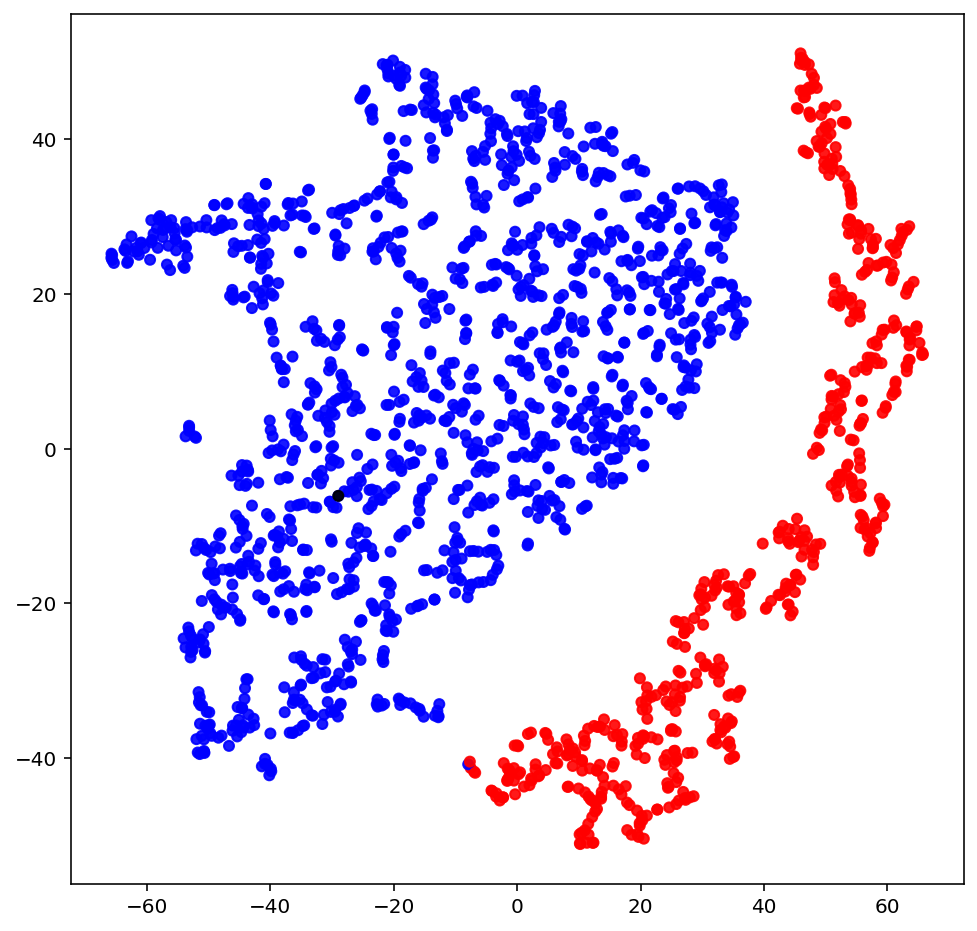

In [63]:
new_feat_idx = 44

new_embedding = embeddings.transform(feats_sm[new_feat_idx:new_feat_idx+1])
print(new_embedding)
final_embeddings = np.concatenate((embeddings, new_embedding), axis=0)
final_labels = np.concatenate((labels_sm, np.array([2], dtype=np.int32)), axis=0)
plt.figure(figsize=(8,8))
plt.scatter(final_embeddings[:, 0], final_embeddings[:, 1], c=colormap[final_labels], s=25, alpha=0.9);

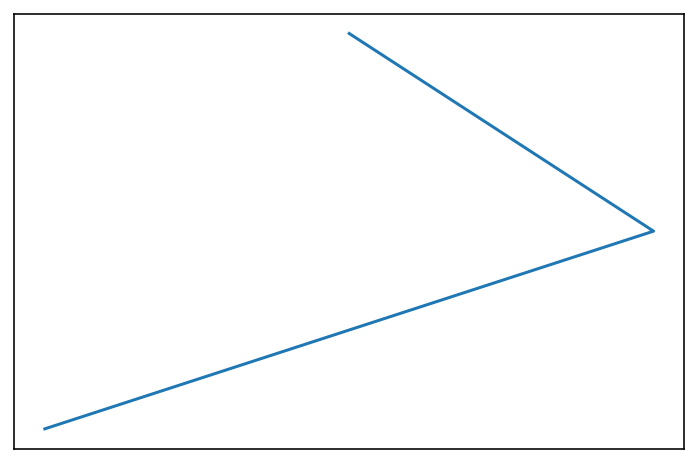

In [64]:
plt.plot([1,3,2],[2,3,4])
plt.tick_params(axis='both', which='both', bottom=False, left=False,
                labelbottom=False, labelleft=False)
plt.show()